In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import math
from transformers import AutoTokenizer, CLIPVisionModel, CLIPImageProcessor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

torch.manual_seed(0)

/Users/danjietang/Documents/Github/GemmaLLM/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
max_context_length = 51
device = "mps"
epochs = 1
batch_size = 256
validation_batch_size = 256
weight_decay = 1e-3
lr = 1e-3
num_layer = 3
head_dim = 64
projection_dim = 512
expansion_factor = 16
checkpoint_filepath = ""
q_head = 8
kv_head = 4
training_data_path = "languages_tokenized_50_train.npy"
eval_data_path = "languages_tokenized_50_eval.npy"

# Load llama2 token embedding

In [3]:
model_id = "NousResearch/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="right")

# Load training data

In [4]:
class Dataset(Dataset):
    def __init__(self, filename):
        # Create memory-mapped array
        self.mmap_data = np.load(filename, mmap_mode='r')
        self.length = self.mmap_data.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return torch.tensor(self.mmap_data[idx])

training_dataset = Dataset(training_data_path)
eval_dataset = Dataset(eval_data_path)

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(eval_dataset, batch_size=validation_batch_size, shuffle=False)

# LLM architecture

In [5]:
class ROPEEmbedding(nn.Module):
    def __init__(self, max_context_length: int, head_dim: int = 64, theta: int = 10000):
        super().__init__()
        self.pos_emb = self.create_embedding(max_context_length, head_dim=head_dim, theta=theta)

    @staticmethod
    def create_embedding(max_context_length: int, head_dim: int = 64, theta: int = 10000) -> torch.Tensor:
        # Angles
        tensor = torch.arange(0, head_dim // 2)
        tensor = torch.repeat_interleave(tensor, 2)
        tensor = -tensor * 2 / head_dim
        tensor = torch.pow(theta, tensor)

        index = torch.arange(max_context_length).float() # This is the m in the formula
        tensor = torch.einsum("i, j -> ij", tensor, index)

        cos_matrix = tensor.cos()
        sin_matrix = tensor.sin()
        sin_matrix[0::2, :] *= -1 # Flipping sign for 0, 2, 4... row of sin matrix

        pos_emb = torch.cat((cos_matrix, sin_matrix), dim=0)
        pos_emb = pos_emb.transpose(1, 0)
        pos_emb = nn.Parameter(pos_emb, requires_grad=False)

        return pos_emb

    @staticmethod
    def flip_for_sin(tensor: torch.Tensor) -> torch.Tensor:
        B, H, S, D = tensor.shape
        # original_shape = tensor.shape
        tensor = tensor.view(B, H, S, D//2, 2) # Get to pairs
        # tensor = tensor.reshape(tensor.shape[0], tensor.shape[1], -1, 2) # Get to pairs
        tensor = tensor[:, :, :, :, [1, 0]].contiguous() # Swap
        # tensor = tensor[..., [1, 0]] 
        tensor = tensor.view(B, H, S, D) # Get back to original shape
        # tensor = tensor.reshape(original_shape) 
        return tensor

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        sequence_length = tensor.shape[2] # Assuming we are using batch_size, head, sequence_length and dim

        tensor = torch.cat((tensor, self.flip_for_sin(tensor)), dim=-1)
        tensor = tensor * self.pos_emb[:sequence_length, :]
        cos, sin = tensor.chunk(chunks=2, dim=-1)
        tensor = cos + sin
        return tensor

class Attention(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 head_dim: int,
                 q_head: int,
                 kv_head: int,
                 embedding: ROPEEmbedding,
                 lora_rank: int = 16,
                 lora_alpha: int = 32):
        super().__init__()
        self.head_dim = head_dim
        self.q_head = q_head
        self.kv_head = kv_head
        self.embedding = embedding
        self.qkv = nn.Linear(hidden_dim, (q_head+kv_head*2)*head_dim)
        self.o = nn.Linear(q_head*head_dim, hidden_dim)
        self.scaler = 1/math.sqrt(head_dim)

        # LoRA
        self.lora_scale = lora_alpha / lora_rank
        self.lora_qkv_a = nn.Linear(hidden_dim, lora_rank)
        self.lora_qkv_b = nn.Linear(lora_rank, (q_head+kv_head*2)*head_dim)
        self.lora_o_a = nn.Linear(q_head*head_dim, lora_rank)
        self.lora_o_b = nn.Linear(lora_rank, hidden_dim)

        if q_head != kv_head:
            # If we are using multi query attention
            assert q_head % kv_head == 0
            self.multi_query_attention = True
            self.q_kv_scale = q_head//kv_head
        else:
            self.multi_query_attention = False

        # Gated attention from Qwen paper
        # Each gate gets one gate score as recommended in the paper
        self.gate = nn.Linear(hidden_dim, q_head)

    def forward(self, tensor: torch.Tensor, attention_mask: torch.Tensor = None, fine_tuning: bool = False) -> torch.Tensor:
        batch_size, seq_len, hid_dim = tensor.shape
        pre_norm_tensor = tensor # Used to calculate gate score

        qkv_tensor = self.qkv(tensor)
        if fine_tuning:
            lora_tensor = self.lora_qkv_a(tensor)
            lora_tensor = self.lora_qkv_b(lora_tensor)
            lora_tensor = lora_tensor * self.lora_scale
            qkv_tensor = lora_tensor + qkv_tensor
        query, key, value = qkv_tensor.split([self.head_dim*self.q_head, self.head_dim*self.kv_head, self.head_dim*self.kv_head], dim=-1)

        query = query.view(batch_size, seq_len, self.q_head, self.head_dim)
        key = key.view(batch_size, seq_len, self.kv_head, self.head_dim)
        value = value.view(batch_size, seq_len, self.kv_head, self.head_dim)

        if self.multi_query_attention:
            # If we are using multi query attention, duplicate key value heads
            key = torch.repeat_interleave(key, self.q_kv_scale, dim=-2)
            value = torch.repeat_interleave(value, self.q_kv_scale, dim=-2)

        # Switch to batch_size, head, seq_len, head_dim
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Apply ROPE
        query = self.embedding(query)
        key = self.embedding(key)

        # Classic self attention
        attention_raw = torch.matmul(query, key.transpose(2, 3))
        attention_scaled = attention_raw * self.scaler
        if attention_mask != None:
            attention_scaled += attention_mask
        attention_score = torch.softmax(attention_scaled, dim=-1)
        value = torch.matmul(attention_score, value)

        # Reshape back to batch_size, seq_len, hid_dim
        value = value.transpose(1, 2).contiguous()
        value = value.view(batch_size, seq_len, hid_dim)

        # Gated attention from Qwen paper
        gate_score = self.gate(pre_norm_tensor)
        gate_score = F.sigmoid(gate_score)
        gate_score = gate_score.repeat_interleave(self.head_dim, dim=-1)
        value = value * gate_score

        # Output layer
        output = self.o(value)
        if fine_tuning:
            lora_tensor = self.lora_o_a(value)
            lora_tensor = self.lora_o_b(lora_tensor)
            lora_tensor = lora_tensor * self.lora_scale
            output = lora_tensor + output

        return output

class FeedForward(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 expansion_factor: int = 4,
                 dropout_ratio: float = 0.1,
                 lora_rank: int = 16,
                 lora_alpha: int = 32):
        super().__init__()
        self.gate_and_up = nn.Linear(hidden_size, hidden_size * expansion_factor * 2)
        self.down = nn.Linear(hidden_size * expansion_factor, hidden_size)
        self.dropout = nn.Dropout(p=dropout_ratio)

        # LoRA
        self.lora_scale = lora_alpha / lora_rank
        self.lora_gate_and_up_a = nn.Linear(hidden_size, lora_rank)
        self.lora_gate_and_up_b = nn.Linear(lora_rank, hidden_size * expansion_factor * 2)
        self.lora_down_a = nn.Linear(hidden_size * expansion_factor, lora_rank)
        self.lora_down_b = nn.Linear(lora_rank, hidden_size)

    def forward(self, tensor: torch.Tensor, fine_tuning: bool = False) -> torch.Tensor:
        gate_and_up = self.gate_and_up(tensor)
        if fine_tuning:
            lora_tensor = self.lora_gate_and_up_a(tensor)
            lora_tensor = self.lora_gate_and_up_b(lora_tensor)
            lora_tensor = lora_tensor * self.lora_scale
            gate_and_up = gate_and_up + lora_tensor
        gate, up = gate_and_up.chunk(chunks=2, dim=-1)
        gate = F.gelu(gate, approximate="tanh")
        tensor = gate * up
        tensor = self.dropout(tensor)
        down_tensor = self.down(tensor)
        if fine_tuning:
            lora_tensor = self.lora_down_a(tensor)
            lora_tensor = self.lora_down_b(lora_tensor)
            lora_tensor = lora_tensor * self.lora_scale
            down_tensor = down_tensor + lora_tensor
        return down_tensor

class MOE(nn.Module):
    def __init__(self, hidden_size: int, num_experts: int = 8, expansion_factor: int = 4, dropout_ratio: float = 0.1, lora_rank: int = 16, lora_alpha: int = 32, device: str = "mps"):
        super().__init__()
        self.gate = nn.Linear(hidden_size, num_experts)
        self.num_experts = num_experts
        self.experts = nn.ModuleList([FeedForward(hidden_size, expansion_factor=expansion_factor, dropout_ratio=dropout_ratio, lora_rank=lora_rank, lora_alpha=lora_alpha) for _ in range(num_experts)])
        self.device = device

    def forward(self, tensor: torch.Tensor, fine_tuning: bool = False) -> tuple[torch.Tensor, torch.Tensor]:
        # Flatten for better manipulation, this is ok because tokens are independent at this stage
        batch_size, seq_len, hidden_size = tensor.shape
        flat_tensor = tensor.reshape(batch_size * seq_len, hidden_size)

        # Pass through the gating network and select experts
        tensor = self.gate(flat_tensor)
        tensor = F.softmax(tensor, dim=-1)

        # The output of this step is a tensor of shape [batch_size * seq_len, 2] with element i in the second dimension representing ith expert selected for this token
        value_tensor, index_tensor = tensor.topk(k=2, dim=-1)

        # Find the load balancing loss
        counts = torch.bincount(index_tensor[:, 0], minlength=self.num_experts)
        frequencies = counts.float() / (batch_size * seq_len) # This is the hard one-hot frequency
        probability = tensor.mean(0) # This is the soft probability
        load_balancing_loss = (probability * frequencies).mean() * float(self.num_experts ** 2)

        # Normalize top1 and top2 score
        top_expert_score = value_tensor[:, 0]
        second_expert_score = value_tensor[:, 1]
        total_score = top_expert_score + second_expert_score
        top_expert_score = top_expert_score / total_score
        second_expert_score = second_expert_score / total_score

        # Split into top 2 experts
        split_tensors = torch.split(index_tensor, 1, dim=-1)
        top_expert, second_expert = split_tensors[0], split_tensors[1]
        indices = torch.arange(batch_size * seq_len).unsqueeze(-1).to(self.device)
        top_expert = torch.cat((indices, top_expert), dim=-1)
        second_expert = torch.cat((indices, second_expert), dim=-1)

        # Sort based on expert selection
        top_expert = top_expert[top_expert[:,1].argsort()]
        second_expert = second_expert[second_expert[:,1].argsort()]

        # Count how many tokens goes to each expert
        top_expert_counts = torch.zeros(self.num_experts, dtype=int)
        for i in range(self.num_experts):
            top_expert_counts[i] = (top_expert[:,1] == i).sum()
        top_expert_counts = top_expert_counts.tolist()

        second_expert_counts = torch.zeros(self.num_experts, dtype=int)
        for i in range(self.num_experts):
            second_expert_counts[i] = (second_expert[:,1] == i).sum()
        second_expert_counts = second_expert_counts.tolist()

        # Split input tokens for each expert
        top_expert_tokens = flat_tensor[top_expert[:,0]]
        second_expert_tokens = flat_tensor[second_expert[:,0]]

        # Split into a list of tensors, element i tensor is for ith expert.
        top_expert_tokens = torch.split(top_expert_tokens, top_expert_counts, dim=0)
        second_expert_tokens = torch.split(second_expert_tokens, second_expert_counts, dim=0)

        # Input into each expert and obtain results in a list
        top_expert_outputs = [self.experts[i](top_expert_tokens[i], fine_tuning) if top_expert_counts[i] > 0 else torch.zeros(0, hidden_size, dtype=torch.float16).to(self.device) for i in range(self.num_experts)]
        second_expert_outputs = [self.experts[i](second_expert_tokens[i], fine_tuning) if second_expert_counts[i] > 0 else torch.zeros(0, hidden_size, dtype=torch.float16).to(self.device) for i in range(self.num_experts)]

        # Combine outputs
        top_expert_outputs = torch.cat(top_expert_outputs, dim=0)
        second_expert_outputs = torch.cat(second_expert_outputs, dim=0)

        # Re-index the output back to original token order
        flat_top_expert_tensor = torch.zeros_like(flat_tensor, dtype=torch.float32).to(self.device)
        flat_top_expert_tensor.index_copy_(0, top_expert[:, 0], top_expert_outputs)

        flat_second_expert_tensor = torch.zeros_like(flat_tensor, dtype=torch.float32).to(self.device)
        flat_second_expert_tensor.index_copy_(0, second_expert[:, 0], second_expert_outputs)

        # Find final output tensor based on weight between top and second expert
        final_tensor = top_expert_score.unsqueeze(-1) * flat_top_expert_tensor + second_expert_score.unsqueeze(-1) * flat_second_expert_tensor

        # Reshape to original [batch_size, seq_len, hidden_size]
        final_tensor = final_tensor.reshape(batch_size, seq_len, hidden_size)

        return final_tensor, load_balancing_loss

class LLMLayer(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 head_dim: int,
                 q_head: int,
                 kv_head: int,
                 embedding: ROPEEmbedding,
                 expansion_factor: int = 4,
                 dropout_ratio: float = 0.1,
                 use_moe: bool = False,
                 num_experts: int = 8,
                 lora_rank: int = 16,
                 lora_alpha: int = 32,
                 device: str = "mps"):
        super().__init__()
        self.use_moe = use_moe

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.mqa = Attention(hidden_dim, head_dim, q_head, kv_head, embedding, lora_rank=lora_rank, lora_alpha=lora_alpha)

        self.norm2 = nn.LayerNorm(hidden_dim)
        if self.use_moe:
            self.moe = MOE(hidden_dim, num_experts=num_experts, expansion_factor=expansion_factor, dropout_ratio=dropout_ratio, lora_rank=lora_rank, device=device)
        else:
            self.ffn = FeedForward(hidden_dim, expansion_factor=expansion_factor, dropout_ratio=dropout_ratio, lora_rank=lora_rank, lora_alpha=lora_alpha)
        self.device = device

    def forward(self, tensor: torch.Tensor, attention_mask: torch.Tensor = None, fine_tuning: bool = False):
        skip_connection = tensor
        tensor = self.norm1(tensor)
        tensor = self.mqa(tensor, attention_mask=attention_mask, fine_tuning=fine_tuning)
        tensor += skip_connection

        skip_connection = tensor
        tensor = self.norm2(tensor)
        if self.use_moe:
            tensor, load_balancing_loss = self.moe(tensor, fine_tuning=fine_tuning)
        else:
            tensor = self.ffn(tensor, fine_tuning=fine_tuning)
            load_balancing_loss = torch.tensor(0.0, dtype=tensor.dtype, device=self.device)# If not using MoE, load-balancing loss is zero

        tensor += skip_connection

        return tensor, load_balancing_loss

class LLM(nn.Module):
    def __init__(self,
                 num_layer: int,
                 vocabulary_size: int,
                 max_context_length: int,
                 hidden_dim: int,
                 expansion_factor: int = 4,
                 head_dim: int = 64,
                 q_head: int = None,
                 kv_head: int = None,
                 dropout_ratio: float = 0.1,
                 theta: int = 10000,
                 use_moe: bool = False,
                 num_experts=8,
                 load_balancing_loss_weight: float = 1e-2,
                 fine_tuning: bool = False,
                 lora_rank: int = 16,
                 lora_alpha: int = 32,
                 device: str = "mps"):
        super().__init__()
        self.embedding = ROPEEmbedding(max_context_length, head_dim=head_dim, theta=theta)
        self.num_layer = num_layer
        self.load_balancing_loss_weight = load_balancing_loss_weight
        self.fine_tuning = fine_tuning

        if q_head == None:
            q_head = (hidden_dim // head_dim)

        if kv_head == None:
            kv_head = (hidden_dim // head_dim)

        if hidden_dim % (head_dim * q_head) != 0 or hidden_dim % (head_dim * kv_head):
            raise ValueError("Error: hidden_dim or projection_dim (if specified) must be divisible by the product of the number of q or kv heads and the head dimension.")

        self.transformer = nn.ModuleList()
        for _ in range(self.num_layer):
            self.transformer.append(LLMLayer(hidden_dim, head_dim, q_head, kv_head, self.embedding, expansion_factor=expansion_factor, dropout_ratio=dropout_ratio, use_moe=use_moe, num_experts=num_experts, lora_rank=lora_rank, lora_alpha=lora_alpha, device=device))
        self.output_norm = nn.LayerNorm(hidden_dim)

        self.classifier = nn.Linear(hidden_dim, vocabulary_size)
        self.device = device

    def begin_fine_tunning(self) -> None:
        self.fine_tuning = True
        for name, param in self.named_parameters():
            if "lora" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def exit_fine_tunning(self) -> None:
        self.fine_tuning = False
        for name, param in self.named_parameters():
            if "pos_emb" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def forward(self, tensor: torch.Tensor, causal_mask: torch.Tensor) -> torch.Tensor:
        # Track load-balancing across layers (only if MoE is used)
        load_balancing_sum = torch.tensor(0.0, device=self.device)

        for layer in self.transformer:
            tensor, load_balancing_loss = layer(tensor, attention_mask=causal_mask, fine_tuning=self.fine_tuning)
            load_balancing_sum += load_balancing_loss

        load_balancing_loss = (load_balancing_sum / self.num_layer) * self.load_balancing_loss_weight

        # Classification
        tensor = self.output_norm(tensor)
        tensor = self.classifier(tensor)

        return tensor, load_balancing_loss

class VLM(nn.Module):
    def __init__(self,
                 num_layer: int,
                 max_context_length: int,
                 word_embeddings_tensor: str,
                 expansion_factor: int = 4,
                 head_dim: int = 64,
                 q_head: int = None,
                 kv_head: int = None,
                 dropout_ratio: float = 0.1,
                 theta: int = 10000,
                 projection_dim: int = None,
                 use_moe: bool = False,
                 num_experts=8,
                 load_balancing_loss_weight: float = 1e-2,
                 fine_tuning: bool = False,
                 lora_rank: int = 16,
                 lora_alpha: int = 32,
                 device: str = "mps"):
        super().__init__()

        # Right now this code is hard coded to use CLIP ViT
        model_id = "openai/clip-vit-large-patch14"
        self.vision_model = CLIPVisionModel.from_pretrained(model_id)
        self.vision_processor = CLIPImageProcessor.from_pretrained(model_id)
        image_dim = 1024
        self.visual_seq_len = 1# Vision sequence length

        # Load model token embeddings
        self.word_embeddings_tensor = torch.load(word_embeddings_tensor)
        zero_row = torch.zeros(1, self.word_embeddings_tensor.shape[1])
        self.word_embeddings_tensor = torch.cat((self.word_embeddings_tensor, zero_row), dim=0).to(device)
        self.vocabulary_size, text_dim = self.word_embeddings_tensor.shape
        self.word_embeddings_tensor.requires_grad = False

        # The token that seperates image tokens from text tokens
        if projection_dim:
            self.seperation_token = nn.Parameter(torch.randn(1, projection_dim))
        else:
            self.seperation_token = nn.Parameter(torch.randn(1, text_dim))

        # Potentially image&text token projection layer
        if projection_dim:
            self.image_projection = image_dim != projection_dim
            self.text_projection = text_dim != projection_dim
        else: # If no explicit projection_dim, use text token_dim
            self.image_projection = image_dim != text_dim
            self.text_projection = False
        if projection_dim:
            if self.image_projection:
                self.image_token_projection = nn.Linear(image_dim, projection_dim)
            if self.text_projection:
                self.text_token_projection = nn.Linear(text_dim, projection_dim)
        else: 
            if self.image_projection:
                self.image_token_projection = nn.Linear(image_dim, text_dim)

        # Create the LLM
        self.llm = LLM(num_layer, self.vocabulary_size, max_context_length, projection_dim if projection_dim else text_dim, expansion_factor=expansion_factor, head_dim=head_dim, q_head=q_head, kv_head=kv_head, dropout_ratio=dropout_ratio, theta=theta, use_moe=use_moe, num_experts=num_experts, load_balancing_loss_weight=load_balancing_loss_weight, fine_tuning=fine_tuning, lora_rank=lora_rank, lora_alpha=lora_alpha, device=device)
        self.device = device

    def forward(self, token_ids: torch.Tensor, image_paths: list[str | None]) -> tuple[torch.Tensor, torch.Tensor]:
        batch_size, text_seq_len = token_ids.shape
        pad_amount = self.visual_seq_len + 1
        multimodal_seq_len = text_seq_len + pad_amount
        assert batch_size == len(image_paths), "Mismatch between text and image inputs"

        # 1. Preallocate input data
        multimodal_input_tensor = torch.empty(
            (batch_size, multimodal_seq_len, self.llm.classifier.in_features), 
            device=self.device, 
            dtype=torch.float32
        )
        
        # 2. Vectorized Text Embedding & Projection
        # input_embeddings.shape = [batch, seq_len, emb_dim]
        input_embeddings = self.word_embeddings_tensor[token_ids].float()
        if self.text_projection:
            input_embeddings = self.text_token_projection(input_embeddings)
        
        # Place text embeddings into the right side of the pre-allocated tensor
        multimodal_input_tensor[:, pad_amount:, :] = input_embeddings

        # 3. Collect images
        has_image_mask = torch.tensor([p is not None for p in image_paths], device=self.device)
        image_indices = torch.where(has_image_mask)[0]

        # Prepare the padding embedding (for batches without images)
        pad_token_emb = self.word_embeddings_tensor[-1:].float()
        if self.text_projection:
            pad_token_emb = self.text_token_projection(pad_token_emb)
        
        # Fill the left side with padding by default
        multimodal_input_tensor[:, :pad_amount, :] = pad_token_emb.repeat(batch_size, pad_amount, 1)

        if len(image_indices) > 0:
            # Process only the actual images found
            actual_images = [Image.open(image_paths[i]).convert("RGB") for i in image_indices.tolist()]
            vision_inputs = self.vision_processor(images=actual_images, return_tensors="pt").to(self.device)
            
            with torch.no_grad():
                outputs = self.vision_model(**vision_inputs)
                visual_tokens = outputs.last_hidden_state[:, 0:self.visual_seq_len, :]
            
            if self.image_projection:
                visual_tokens = self.image_token_projection(visual_tokens)
                
            # Scatter visual tokens and separation tokens into the multimodal tensor
            multimodal_input_tensor[image_indices, :self.visual_seq_len, :] = visual_tokens
            multimodal_input_tensor[image_indices, self.visual_seq_len, :] = self.seperation_token

        # 4. 3D Causal Mask
        causal_mask = torch.triu(torch.ones(multimodal_seq_len, multimodal_seq_len) * float('-inf'), diagonal=1).to(device)
        causal_mask.requires_grad = False
        
        # 5. Forward to LLM
        tensor, load_balancing_loss = self.llm(multimodal_input_tensor, causal_mask)
        tensor = tensor[:, pad_amount:, :]
        tensor = tensor.contiguous()
    
        return tensor, load_balancing_loss

# Prepare for training

In [6]:
def save_checkpoint(model, optimizer, epoch, loss):
    if isinstance(model, nn.DataParallel):
        model_to_save = model.module
    else:
        model_to_save = model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_to_save.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    timestamp = time.strftime('%Y%m%d_%H%M%S')
    filename = f'checkpoint_{epoch}_{loss}.pth.tar'
    torch.save(checkpoint, filename)
    print(f'Checkpoint saved at epoch {epoch} as {filename}')

def load_checkpoint(model, optimizer, filename) -> int:
    checkpoint = torch.load(filename, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f'Checkpoint loaded from epoch {epoch} with loss {loss}')
    return epoch

In [7]:
vit = VLM(num_layer, max_context_length, 'word_embeddings_tensor_llama3.pt', projection_dim=projection_dim, expansion_factor=expansion_factor, use_moe=False, q_head=q_head, kv_head=kv_head, device=device).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=lr, weight_decay=weight_decay)

# Initialize the learning rate scheduler
total_steps = epochs*len(training_loader)
warmup_steps = int(total_steps * 0.01)

# Warmup: LR linearly increases from 0 → base LR over warmup_steps
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)

# Cosine annealing: after warmup
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=(total_steps - warmup_steps), eta_min=3e-5)

# Combine them
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])

if checkpoint_filepath != None and checkpoint_filepath != "":
    current_epoch = load_checkpoint(llm, optimizer, checkpoint_filepath) + 1
else:
    current_epoch = 0

print("This model has", sum(p.numel() for p in vit.parameters()), "parameters.")

This model has 413195097 parameters.


In [9]:
loss_train = []
loss_valid = []

# Training code

100%|███████████████████████████████████████| 7813/7813 [33:49<00:00,  3.85it/s]


Checkpoint saved at epoch 0 as checkpoint_0_1.743630702907841.pth.tar
Training loss:  1.9085582312057494
Validation loss:  1.743630702907841


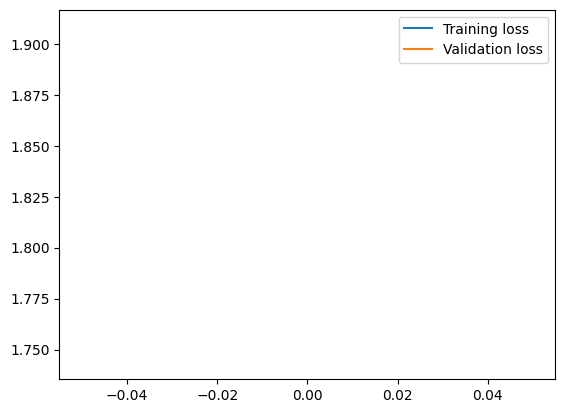

In [10]:
for epoch in range(current_epoch, epochs):
    loss_train_epoch = []
    loss_val_epoch = []

    vit.train()
    for data in tqdm(training_loader):
        # Teacher forcing
        input_data = data[:, :-1].long().to(device)
        target_data = data[:, 1:].long().to(device)

        # Forward pass
        prediction, load_balancing_loss = vit(input_data, [None] * input_data.shape[0])

        # Change shape for loss calculation
        prediction = prediction.view(-1, prediction.shape[-1])
        target_data = target_data.reshape(-1)

        loss = criterion(prediction, target_data) + load_balancing_loss # Calculate loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Record loss
        loss_train_epoch.append(loss.item())
        scheduler.step()

    loss_train.append(np.mean(loss_train_epoch))

    vit.eval()
    with torch.no_grad():
        for data in tqdm(validation_loader):
            # Teacher forcing
            input_data = data[:, :-1].long().to(device)
            target_data = data[:, 1:].long().to(device)

            # Forward pass
            prediction, load_balancing_loss = vit(input_data, [None] * input_data.shape[0])

            # Change shape for loss calculation
            prediction = prediction.view(-1, prediction.shape[-1])
            target_data = target_data.reshape(-1)

            loss = criterion(prediction, target_data) + load_balancing_loss # Calculate loss

            # Record loss
            loss_val_epoch.append(loss.item())

        loss_valid.append(np.mean(loss_val_epoch))

    # Save checkpoint
    save_checkpoint(vit, optimizer, epoch, loss_valid[-1])

    plt.plot(loss_train, label="Training loss")
    plt.plot(loss_valid, label="Validation loss")
    print("Training loss: ", loss_train[-1])
    print("Validation loss: ", loss_valid[-1])
    plt.legend()
    plt.show()

# Inference

In [11]:
temperature = 0.5

In [ ]:
tokenized_sentence = []

In [20]:
sentence = "arXiv is an open-access"
tokenized_sentence = tokenizer(sentence)["input_ids"]
if tokenized_sentence[-1] == 2:
    tokenized_sentence = tokenized_sentence[:-1]
vit.eval()

with torch.no_grad():
    while(tokenized_sentence[-1] != tokenizer.eos_token_id and len(tokenized_sentence) < max_context_length): # Keep iterating until reaches end of sentence or max token limit
        # Preparing input
        tokenized_sentence_tensor = torch.tensor(tokenized_sentence).unsqueeze(0).to(device)

        # Make prediction
        prediction, _ = vit(tokenized_sentence_tensor, [None])
        prediction = prediction[0][-1] # We only care about last token
        prediction = prediction / temperature
        prediction = F.softmax(prediction, dim=-1)
        output_token = torch.multinomial(prediction, 1)

        # Append to conversation history
        tokenized_sentence.append(output_token.item())
        
tokens = tokenizer.decode(tokenized_sentence, skip_special_tokens=True)
print(tokens)

arxiv 是一个开源的例子，一个包含一个函数的特征。
